In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray
import numpy as np
import glob
from shapely.geometry import Point
import os
import contextily as cx

In [ ]:
#ROMA
CITY_NAME = "Roma"
REGION_NAME = "Lazio"
COUNTRY_CODE = "ITA"

#MILANO
#CITY_NAME = "Milano"
#REGION_NAME = "Lombardia"
#COUNTRY_CODE = "ITA"

#VALENCIA
#CITY_NAME = "Valencia"
#REGION_NAME = "Comunidad Valenciana" 
#COUNTRY_CODE = "ESP"

#MADRID
#CITY_NAME = "Madrid"
#REGION_NAME = "Comunidad de Madrid"
#COUNTRY_CODE = "ESP"

#LISBONA
#CITY_NAME = "Lisboa"
#REGION_NAME = "Lisboa"
#COUNTRY_CODE = "PRT"

# VENEZIA
#CITY_NAME = "Venezia"
#REGION_NAME = "Veneto"
#COUNTRY_CODE = "ITA"

DATA_FOLDER = "data/"
ECA_FOLDER=os.path.join(DATA_FOLDER, "ECA_blend_tx/")
STATIONS_FILE_PATH= os.path.join(ECA_FOLDER, "stations.txt")
ERA5_FOLDER_PATH =os.path.join(DATA_FOLDER, "derived-era5-land-daily-statistics/")
GADM_FILE_PATH=os.path.join(DATA_FOLDER, "gadm_410_europe.gpkg")
NDVI_FOLDER_PATH=os.path.join(DATA_FOLDER, "sentinel2_ndvi/")

print(f"Analyzing City: {CITY_NAME}")

Configuration loaded successfully.
Analyzing City: Roma


In [ ]:
try:
    gadm_inspector_gdf= gpd.read_file(GADM_FILE_PATH)
    country_gdf= gadm_inspector_gdf[gadm_inspector_gdf['GID_0'] == COUNTRY_CODE]
    if not country_gdf.empty:
        available_regions = country_gdf['NAME_1'].unique()
        print(f"\nAvailable regions (NAME_1) in {COUNTRY_CODE}:")
        print("------------------------------------------")
        for region in sorted(available_regions):
            print(f"- {region}")

        
        region_specific_gdf =country_gdf[country_gdf['NAME_1'] == REGION_NAME]

        if not region_specific_gdf.empty:
            available_cities = region_specific_gdf['NAME_2'].unique()
            print(f"\nAvailable provinces/cities (NAME_2) in '{REGION_NAME}':")
            print("---------------------------------------------------")
            for city in sorted(available_cities):
                print(f"- {city}")
        else:
            print(f"\nCould not find any data for the region '{REGION_NAME}'. Please check the spelling against the list above and update Cell 1.")

    else:
        print(f"could not find any data for the country code '{COUNTRY_CODE}'.")

except Exception as e:
    print(f"an error occurred during GADM inspection: {e}")

--- Inspecting GADM data to find correct names ---
Successfully loaded GADM file for inspection.

Available regions (NAME_1) in ITA:
------------------------------------------
- Abruzzo
- Apulia
- Basilicata
- Calabria
- Campania
- Emilia-Romagna
- Friuli-Venezia Giulia
- Lazio
- Liguria
- Lombardia
- Marche
- Molise
- Piemonte
- Sardegna
- Sicily
- Toscana
- Trentino-Alto Adige
- Umbria
- Valle d'Aosta
- Veneto

Available provinces/cities (NAME_2) in 'Lazio':
---------------------------------------------------
- Frosinone
- Latina
- Rieti
- Roma
- Viterbo


--- Section 1: Processing GADM Administrative Boundaries ---
Successfully loaded GADM file.
Successfully extracted and re-projected boundaries for Roma and Lazio.


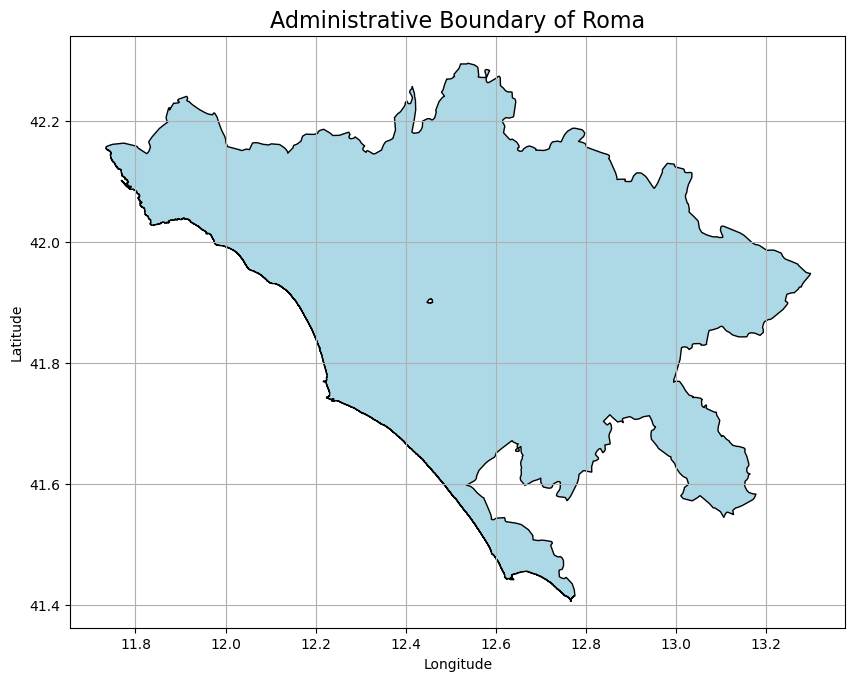

In [ ]:
try:
    gadm_gdf = gpd.read_file(GADM_FILE_PATH)
    print(f"Successfully loaded GADM file.")

    city_gdf = gadm_gdf[
        (gadm_gdf['GID_0'] == COUNTRY_CODE) &
        (gadm_gdf['NAME_1'] == REGION_NAME) &
        (gadm_gdf['NAME_2'] == CITY_NAME)
    ]
    
    region_gdf = gadm_gdf[
        (gadm_gdf['GID_0'] == COUNTRY_CODE) &
        (gadm_gdf['NAME_1']== REGION_NAME)
    ]

    if city_gdf.empty or region_gdf.empty:
        raise ValueError(f"Could not find shapes for '{CITY_NAME}' in '{REGION_NAME}'. Check spelling/capitalization.")

    city_boundary= city_gdf.dissolve()
    region_boundary= region_gdf.dissolve()
    
    city_boundary =city_boundary.to_crs("EPSG:4326")
    region_boundary= region_boundary.to_crs("EPSG:4326")
    
    print(f"Successfully extracted and re-projected boundaries for {CITY_NAME} and {REGION_NAME}.")

    fig, ax = plt.subplots(figsize=(10, 10))
    city_boundary.plot(ax=ax, edgecolor='black', facecolor='lightblue')
    ax.set_title(f'Administrative Boundary of {CITY_NAME}', fontsize=16)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True)
    plt.show()

except Exception as e:
    print(f"An error occurred in the GADM section: {e}")


--- Section 2: Processing ERA5 Meteorological Data ---
Using City bbox (EPSG:4326): [11.73347187 41.40736008 13.29717636 42.29699326]
Found 6 ERA5 files
ERA5 longitudes already in [-180, 180].
Successfully clipped ERA5 data and converted to Celsius.


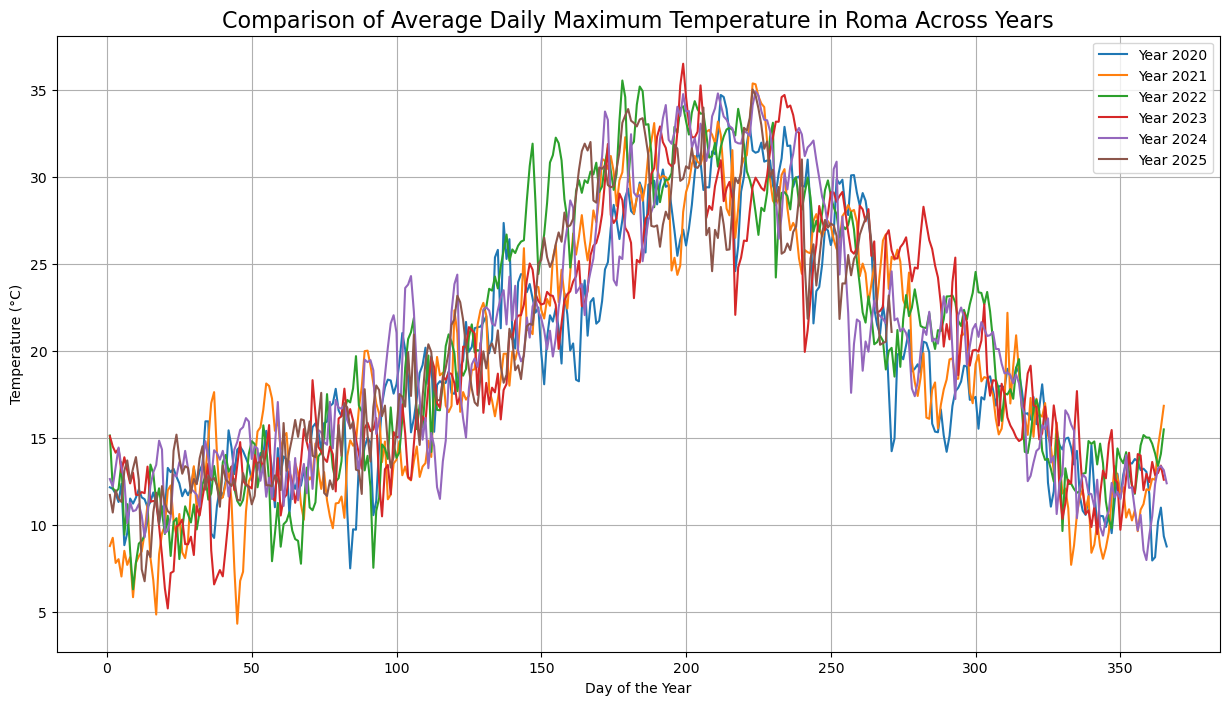


Comparing the spatial temperature pattern for July 1st across different years...


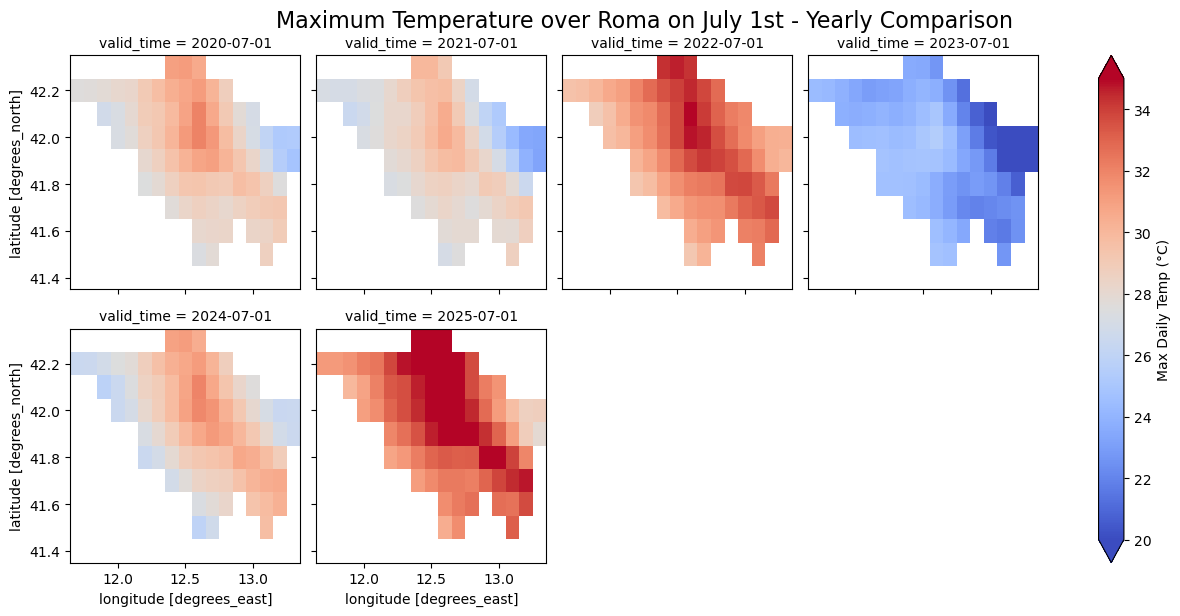

In [ ]:
try:
    assert 'city_boundary' in globals(), "city_boundary is not defined from Section 1."
    assert not city_boundary.empty, "city_boundary is empty."
    city_geom=city_boundary.geometry.buffer(0)
    city_bbox= city_boundary.total_bounds
    print(f"Using City bbox (EPSG:4326): {city_bbox}")
    search_pattern= os.path.join(ERA5_FOLDER_PATH, "*_2m_temperature_daily_maximum.nc")
    all_temp_files=sorted(glob.glob(search_pattern))
    print(f"Found {len(all_temp_files)} ERA5 files")
    assert len(all_temp_files) > 0, f"No ERA5 files found at {search_pattern}"

    ds =xr.open_mfdataset(all_temp_files, engine="netcdf4", combine="by_coords")

    x_name, y_name = ("longitude", "latitude")
    ds = ds.rio.set_spatial_dims(x_dim=x_name, y_dim=y_name).rio.write_crs("EPSG:4326")
    lon = ds[x_name]
    if float(lon.max()) > 180:
        new_lon = (((lon + 180) % 360) - 180)
        ds = ds.assign_coords({x_name: new_lon}).sortby(x_name)
        print("Converted ERA5 longitudes to [-180, 180).")
    else:
        print("ERA5 longitudes already in [-180, 180].")

    minx, miny, maxx, maxy= city_bbox
    t2m_subset = ds["t2m"].sel({x_name: slice(minx, maxx), y_name: slice(maxy, miny)})
    if t2m_subset.sizes.get(x_name, 0)==0 or t2m_subset.sizes.get(y_name, 0) == 0:
        raise RuntimeError("City bounding box falls outside the ERA5 data extent. Check CRS or names.")
    t2m = ds["t2m"].rio.set_spatial_dims(x_dim=x_name, y_dim=y_name).rio.write_crs("EPSG:4326")
    city_temp_multiyear_clipped = t2m.rio.clip(city_geom.tolist(), city_boundary.crs, all_touched=True, from_disk=True)

    city_temp_multiyear_celsius=city_temp_multiyear_clipped - 273.15
    print("Successfully clipped ERA5 data and converted to Celsius.")

    fig, ax=plt.subplots(figsize=(15, 8))
    for year, data_for_year in city_temp_multiyear_celsius.groupby('valid_time.year'):
        mean_daily_temp = data_for_year.mean(dim=["latitude", "longitude"])
        ax.plot(mean_daily_temp['valid_time.dayofyear'], mean_daily_temp.values, label=f'Year {year}')

    ax.set_title(f'Comparison of Average Daily Maximum Temperature in {CITY_NAME} Across Years', fontsize=16)
    ax.set_xlabel('Day of the Year')
    ax.set_ylabel('Temperature (°C)')
    ax.legend()
    ax.grid(True)
    plt.show()

    print(f"\nComparing the spatial temperature pattern for July 1st across different years...")
    available_years=np.unique(city_temp_multiyear_celsius['valid_time.year'].values)
    dates_to_plot_str= [f"{year}-07-01" for year in available_years]
    existing_dates_to_plot= [d for d in pd.to_datetime(dates_to_plot_str) if d in pd.to_datetime(city_temp_multiyear_celsius.valid_time.values)]
    
    if existing_dates_to_plot:
        temp_on_july1_multiyear= city_temp_multiyear_celsius.sel(valid_time=existing_dates_to_plot)
        temp_on_july1_multiyear.plot(
            col="valid_time", col_wrap=4, cmap='coolwarm',
            cbar_kwargs={'label': 'Max Daily Temp (°C)'}, vmin=20, vmax=35
        )
        plt.suptitle(f'Maximum Temperature over {CITY_NAME} on July 1st - Yearly Comparison', y=1.02, fontsize=16)
        plt.show()

except Exception as e:
    print(f"An error occurred in the ERA5 section: {e}")


--- Section 3: Processing Sentinel-2 NDVI Vegetation Data ---
Successfully loaded NDVI file: data/sentinel2_ndvi/ndvi_2020-12-01_2021-03-01.tif
Clipped NDVI data to city boundary.


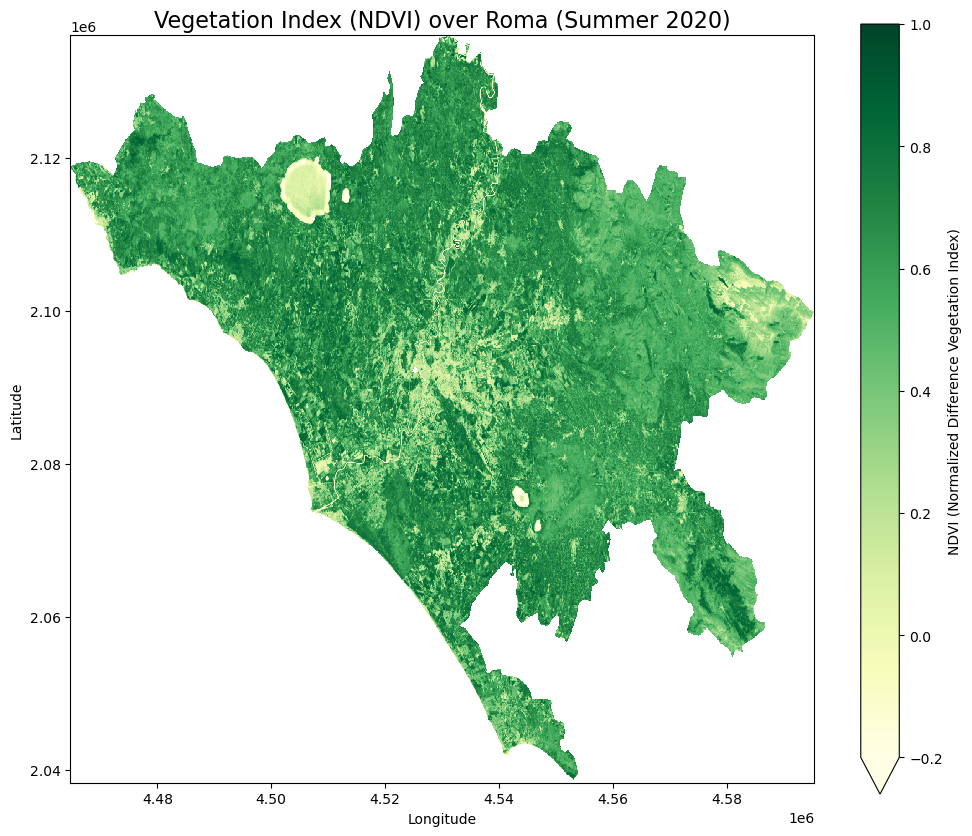

In [ ]:

def convert_ndvi_to_real_scale(ndvi_dataarray, nodata_val):
    if ndvi_dataarray.ndim ==3:
        ndvi_dataarray = ndvi_dataarray.squeeze()
    values= ndvi_dataarray.values.astype(float)
    values[values==nodata_val] = np.nan
    values =(values / 254.0) * 2.0 - 1.0
    return xr.DataArray(values, coords=ndvi_dataarray.coords, dims=ndvi_dataarray.dims)

#ndvi_filepath = os.path.join(NDVI_FOLDER_PATH, "ndvi_2020-06-01_2020-09-01.tif") # summer
#ndvi_filepath = os.path.join(NDVI_FOLDER_PATH, "ndvi_2020-03-01_2020-06-01.tif") # spring
#ndvi_filepath = os.path.join(NDVI_FOLDER_PATH, "ndvi_2020-09-01_2020-12-01.tif") # autum
ndvi_filepath=os.path.join(NDVI_FOLDER_PATH, "ndvi_2020-12-01_2021-03-01.tif") # winter




try:
    ndvi_da_raw =rioxarray.open_rasterio(ndvi_filepath)
    print(f"Successfully loaded NDVI file: {ndvi_filepath}")

    ndvi_real_scale = convert_ndvi_to_real_scale(ndvi_da_raw, nodata_val=255)
    ndvi_real_scale = ndvi_real_scale.rio.write_crs(ndvi_da_raw.rio.crs)
    
    geometries_for_clipping =city_boundary.geometry.tolist()
    city_ndvi_clipped =ndvi_real_scale.rio.clip(geometries_for_clipping, city_boundary.crs)
    print("Clipped NDVI data to city boundary.")
    
    fig, ax = plt.subplots(figsize=(12, 10))
    city_ndvi_clipped.plot(
        ax=ax, cmap='YlGn', vmin=-0.2, vmax=1.0,
        cbar_kwargs={'label': 'NDVI (Normalized Difference Vegetation Index)'}
    )
    city_boundary.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=2)
    ax.set_title(f'Vegetation Index (NDVI) over {CITY_NAME} (Summer 2020)', fontsize=16)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

except FileNotFoundError:
    print(f"ERROR: Could not find NDVI file at {ndvi_filepath}")

\n--- Section 7: Seasonal NDVI Comparison ---
An error occurred during seasonal NDVI analysis: Unable to allocate 24.1 GiB for an array with shape (52389, 61776) and data type float64


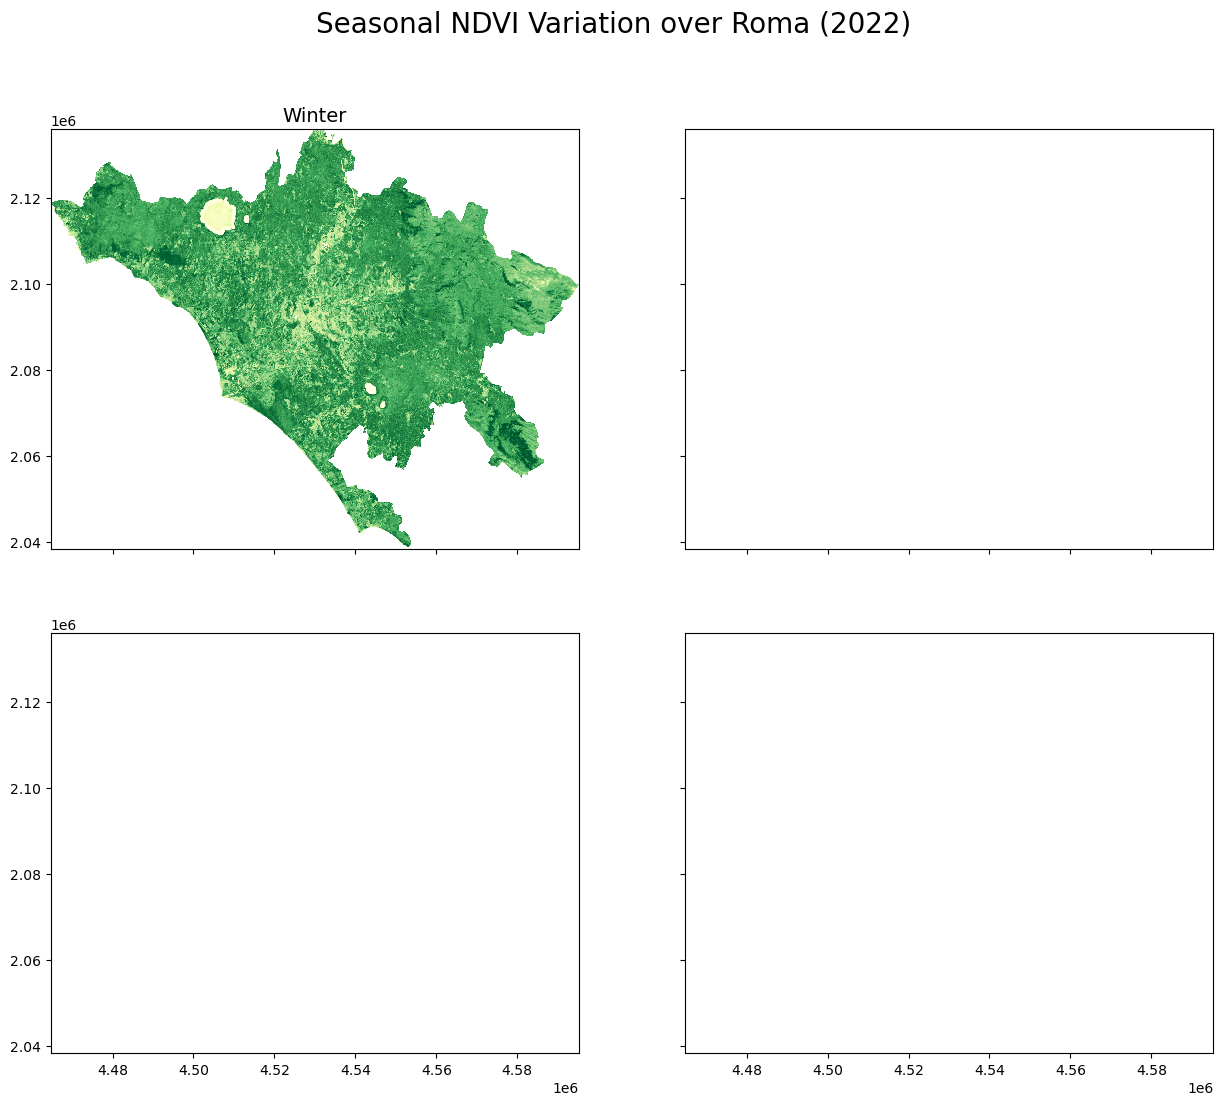

In [ ]:
try:
    YEAR_TO_ANALYZE = 2022
    
    seasonal_ndvi_files = {
        'Winter': os.path.join(NDVI_FOLDER_PATH, f"ndvi_{YEAR_TO_ANALYZE-1}-12-01_{YEAR_TO_ANALYZE}-03-01.tif"),
        'Spring': os.path.join(NDVI_FOLDER_PATH, f"ndvi_{YEAR_TO_ANALYZE}-03-01_{YEAR_TO_ANALYZE}-06-01.tif"),
        'Summer': os.path.join(NDVI_FOLDER_PATH, f"ndvi_{YEAR_TO_ANALYZE}-06-01_{YEAR_TO_ANALYZE}-09-01.tif"),
        'Autumn': os.path.join(NDVI_FOLDER_PATH, f"ndvi_{YEAR_TO_ANALYZE}-09-01_{YEAR_TO_ANALYZE}-12-01.tif")
    }

    fig, axes= plt.subplots(2, 2, figsize=(15, 12), sharex=True, sharey=True)
    fig.suptitle(f'Seasonal NDVI Variation over {CITY_NAME} ({YEAR_TO_ANALYZE})', fontsize=20)
    
    axes_flat =axes.flatten()
    
    for i, (season, filepath) in enumerate(seasonal_ndvi_files.items()):
        ax = axes_flat[i]
        
        ndvi_raw =rioxarray.open_rasterio(filepath)
        ndvi_scaled=convert_ndvi_to_real_scale(ndvi_raw, nodata_val=255)
        city_ndvi_clipped= ndvi_scaled.rio.clip(city_boundary.geometry.tolist(), city_boundary.crs)
        
        im =city_ndvi_clipped.plot(
            ax=ax,
            cmap='YlGn',
            vmin=-0.2, vmax=1.0,
            add_colorbar=False  
        )
        
        ax.set_title(season, fontsize=14)
        ax.set_xlabel('')
        ax.set_ylabel('')

    fig.colorbar(im.get_children()[0], ax=axes, orientation='vertical', fraction=0.025, pad=0.04, label='NDVI')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    plt.show()

except FileNotFoundError as e:
    print(f"ERROR: Could not find one of the seasonal NDVI files. {e}")
except Exception as e:
    print(f"An error occurred during seasonal NDVI analysis: {e}")


--- Section 4: Processing ECAD Ground-Truth Data ---
Loaded and parsed metadata for 8568 stations.
Found 97 station(s) within Lazio.

Comparing with closest station: ROMA_LANCIANI (STAID: 26023)


C:\Users\drugm\AppData\Local\Temp\ipykernel_29312\4190596287.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  city_center = city_boundary.geometry.centroid.iloc[0]
C:\Users\drugm\AppData\Local\Temp\ipykernel_29312\4190596287.py:37: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region_stations['distance_to_city'] = region_stations.geometry.distance(city_center)
C:\Users\drugm\AppData\Local\Temp\ipykernel_29312\4190596287.py:58: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

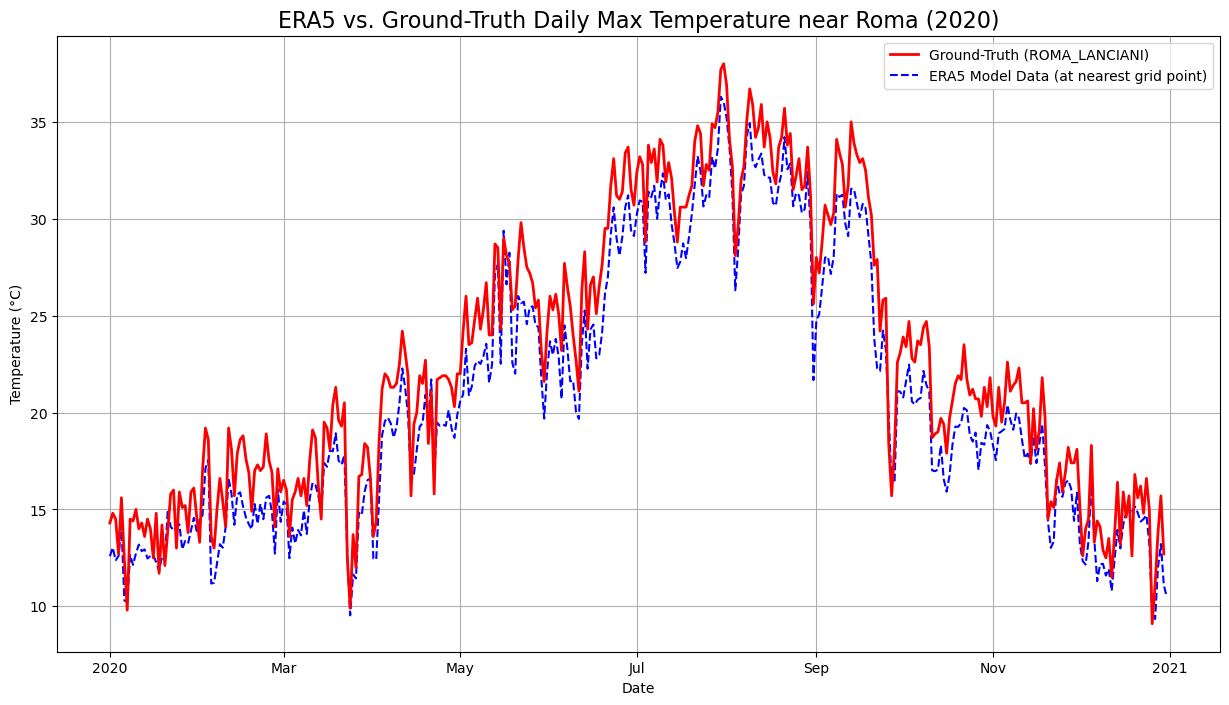

In [ ]:
try:
    stations_df = pd.read_csv(
        STATIONS_FILE_PATH, skiprows=18, sep=',', skipinitialspace=True, 
        names=['STAID', 'STANAME', 'CN', 'LAT', 'LON', 'HGHT']
    )
    def dms_to_dd(dms_str):
        if isinstance(dms_str, str):
            try:
                sign= -1 if '-' in dms_str else 1
                dms_str = dms_str.replace('+', '').replace('-', '')
                parts = dms_str.split(':')
                degrees, minutes, seconds = float(parts[0]), float(parts[1]), float(parts[2])
                return sign * (degrees + minutes/60.0 + seconds/3600.0)
            except: return np.nan
        return np.nan
    stations_df['LAT_DD']=stations_df['LAT'].apply(dms_to_dd)
    stations_df['LON_DD'] =stations_df['LON'].apply(dms_to_dd)
    stations_df.dropna(subset=['LAT_DD', 'LON_DD'], inplace=True)
    print(f"Loaded and parsed metadata for {len(stations_df)} stations.")

    stations_gdf =gpd.GeoDataFrame(
        stations_df, geometry=gpd.points_from_xy(stations_df.LON_DD, stations_df.LAT_DD), crs="EPSG:4326"
    )
    region_stations =gpd.clip(stations_gdf, region_boundary).copy()
    print(f"Found {len(region_stations)} station(s) within {REGION_NAME}.")

    if not region_stations.empty:
        city_center = city_boundary.geometry.centroid.iloc[0]
        region_stations['distance_to_city'] = region_stations.geometry.distance(city_center)
        closest_station=region_stations.sort_values(by='distance_to_city').iloc[0]
        
        staid =closest_station['STAID']
        lat, lon= closest_station['LAT_DD'], closest_station['LON_DD']
        
        print(f"\nComparing with closest station: {closest_station['STANAME'].strip()} (STAID: {staid})")
        
        station_temp_filepath = os.path.join(ECA_FOLDER, f"TX_STAID{staid:06}.txt")
        header_line_num = 0
        with open(station_temp_filepath, 'r') as f:
            for i, line in enumerate(f):
                if 'STAID, SOUID,    DATE' in line:
                    header_line_num = i
                    break
        
        temp_df =pd.read_csv(
            station_temp_filepath, skiprows=header_line_num + 1, sep=',',
            skipinitialspace=True, names=['STAID', 'SOUID', 'DATE', 'TX', 'Q_TX']
        )
        
        temp_df['TX'].replace(-9999, np.nan, inplace=True)
        temp_df['DATE']=pd.to_datetime(temp_df['DATE'], format='%Y%m%d')
        
        station_temp_2020 = temp_df[temp_df['DATE'].dt.year == 2020].copy()
        station_temp_2020['TX_Celsius'] = station_temp_2020['TX'] / 10.0

        era5_at_station_2020 = city_temp_multiyear_celsius.sel(
            latitude=lat, longitude=lon, method='nearest'
        ).sel(valid_time='2020')

        fig, ax = plt.subplots(figsize=(15, 8))
        ax.plot(station_temp_2020['DATE'], station_temp_2020['TX_Celsius'], label=f'Ground-Truth ({closest_station["STANAME"].strip()})', color='red', linewidth=2, zorder=10)
        era5_at_station_2020.plot(ax=ax, label='ERA5 Model Data (at nearest grid point)', color='blue', linestyle='--')
        
        ax.set_title(f'ERA5 vs. Ground-Truth Daily Max Temperature near {CITY_NAME} (2020)', fontsize=16)
        ax.set_xlabel('Date')
        ax.set_ylabel('Temperature (°C)')
        ax.legend()
        ax.grid(True)
        plt.show()

except FileNotFoundError:
    print(f"ERROR: Could not find the stations file at '{STATIONS_FILE_PATH}'. Ensure 'ECA_blend_tx.zip' is unzipped.")
except Exception as e:
    print(f"An unexpected error occurred in the ECAD section: {e}")


--- Section 5: Processing ERA5 Wind Data ---
Successfully loaded, clipped, and calculated wind speed for 2022


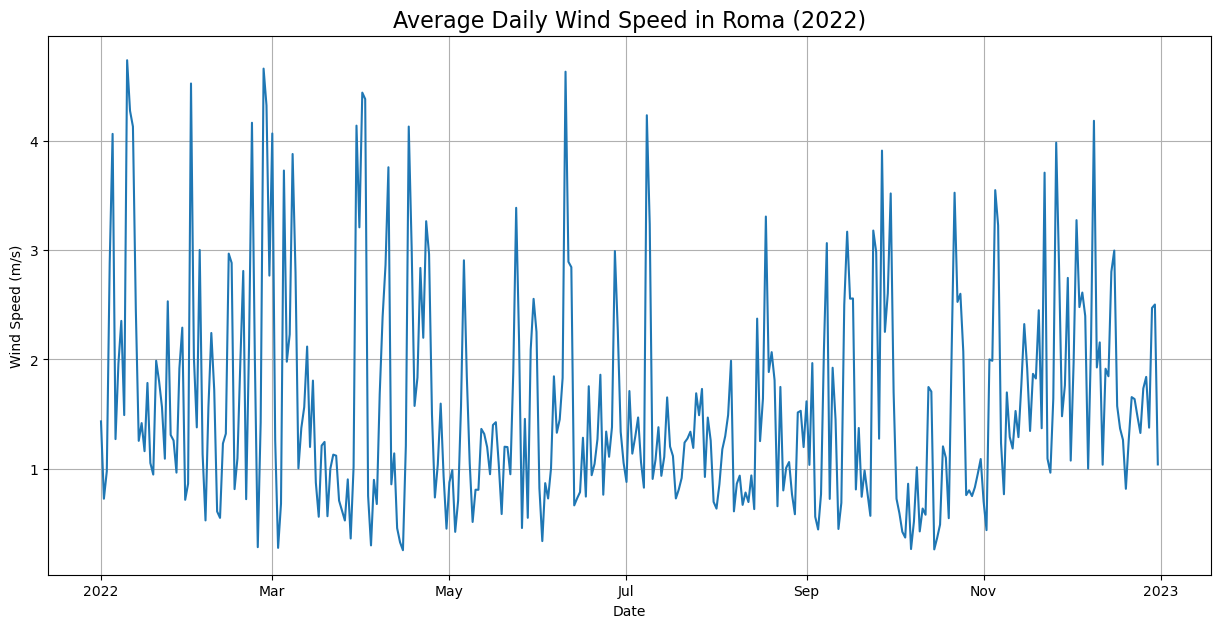

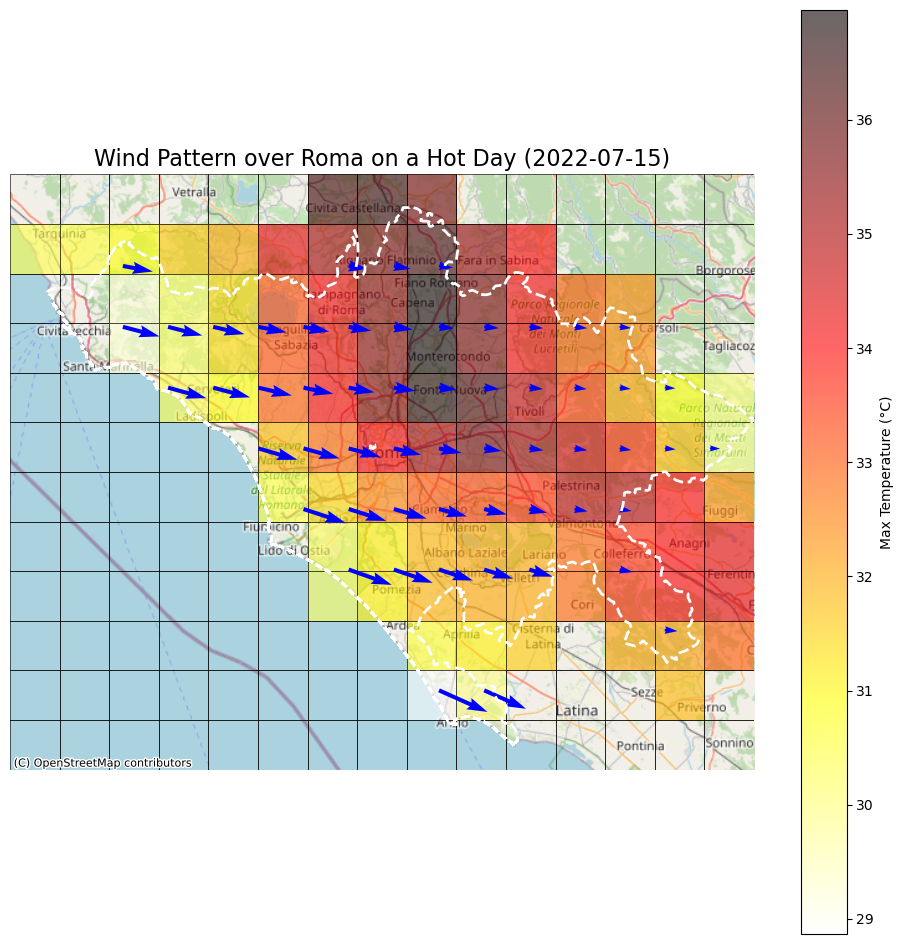

In [ ]:


try:
    YEAR_TO_ANALYZE = 2022
    u_wind_path= os.path.join(ERA5_FOLDER_PATH, f"{YEAR_TO_ANALYZE}_10m_u_component_of_wind_daily_mean.nc")
    v_wind_path =os.path.join(ERA5_FOLDER_PATH, f"{YEAR_TO_ANALYZE}_10m_v_component_of_wind_daily_mean.nc")
    
    ds_u= xr.open_dataset(u_wind_path)
    ds_v =xr.open_dataset(v_wind_path)

    ds_wind = xr.merge([ds_u, ds_v])
    
    ds_wind = ds_wind.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude").rio.write_crs("EPSG:4326")
    city_wind_clipped= ds_wind.rio.clip(city_boundary.geometry.tolist(), city_boundary.crs)

    wind_speed =np.sqrt(city_wind_clipped['u10']**2 + city_wind_clipped['v10']**2)
    city_wind_clipped['wind_speed'] = wind_speed
    print("Successfully loaded, clipped, and calculated wind speed for", YEAR_TO_ANALYZE)

    mean_daily_wind_speed =city_wind_clipped['wind_speed'].mean(dim=["latitude", "longitude"])
    
    fig, ax= plt.subplots(figsize=(15, 7))
    mean_daily_wind_speed.plot(ax=ax)
    ax.set_title(f'Average Daily Wind Speed in {CITY_NAME} ({YEAR_TO_ANALYZE})', fontsize=16)
    ax.set_xlabel('Date')
    ax.set_ylabel('Wind Speed (m/s)')
    ax.grid(True)
    plt.show()

    HOT_DAY = f'{YEAR_TO_ANALYZE}-07-15'
    
    wind_on_hot_day =city_wind_clipped.sel(valid_time=HOT_DAY, method='nearest')
    temp_on_hot_day=city_temp_multiyear_celsius.sel(valid_time=HOT_DAY, method='nearest')

    TARGET_CRS ="EPSG:3857"
    
    temp_on_hot_day_map= temp_on_hot_day.rio.reproject(TARGET_CRS)
    city_boundary_map =city_boundary.to_crs(TARGET_CRS)
    

    lon_vals, lat_vals =np.meshgrid(wind_on_hot_day['longitude'].values, wind_on_hot_day['latitude'].values)
    u_vals = wind_on_hot_day['u10'].values.flatten()
    v_vals = wind_on_hot_day['v10'].values.flatten()

    wind_points_gdf = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy(lon_vals.flatten(), lat_vals.flatten()),
        crs="EPSG:4326"
    )
    wind_points_map_gdf = wind_points_gdf.to_crs(TARGET_CRS)
    x_map =wind_points_map_gdf.geometry.x
    y_map=wind_points_map_gdf.geometry.y

    fig, ax =plt.subplots(figsize=(12, 12))
    
    temp_on_hot_day_map.plot(ax=ax, cmap='hot_r', 
                             cbar_kwargs={'label': 'Max Temperature (°C)'},
                             alpha=0.6,           
                             edgecolor='black', 
                             linewidth=0.5)   
    
    ax.quiver(x_map, y_map, u_vals, v_vals, color='blue', scale=50)
    
    city_boundary_map.plot(ax=ax, edgecolor='white', facecolor='none', linewidth=2, linestyle='--')
    
    cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)
    
    ax.set_title(f'Wind Pattern over {CITY_NAME} on a Hot Day ({HOT_DAY})', fontsize=16)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_axis_off() 
    plt.show()

except Exception as e:
    print(f"An error occurred in the wind analysis section: {e}")